## Run the report generation script

Here we run the script to generate a drift log analysis report using one of the example LAS files in `../LAS_ExampleFiles`.  The script calls seven individual subroutines that each produce a separate plot.  We will briefly describe each of these in cells that follow.  The script, in its entirety, can be run in Jupyter using command.

In [ ]:
%run RadiusOfCurvatureWorkspace2.py

However, to demonstrate how it works, we'll walk-through it in blocks.  The script below is simply top two-thirds of the complete script above.  It generates a dataframe of drift log data from a datafile that the user selects from a drift log `.LAS` file.  Within the script, selection, importation and pre-processing directives follow module loads and script subroutine definitions.  A `tkinter` file dialog, or two, prompt the user to select a save directory as well as a source data file to be analyzed.

In [1]:
%run GenLogDataTable.py

LAS file source? (0 = Eaton, 1 = Eaton (CSV)): 0
Enter an identifier for this job to be used in figure titles: 20170406_EXAMPLE
Enter value to depth-shift (neg. for uphole, 0.0 for none): -14.9
Enter Inner Diameter (in inches) of well casing or borehole diameter: 12.5
Enter the length of the pump to be inserted (0.0 for none): 250


In [10]:
# Successor method, .iloc(), for extracting dataFrame records
#  by numeric integer indices.
reportData = LogDataTable[['Depth', 'DevAzimuth', 'DevInclination', 
    'DevComp_North', 'DevComp_East', 'DevComp_Down', 
    'Dogleg', 'EffDiam']].iloc[ExtractionIndices.astype(int)]

`WellArcLengthCalculator()` is a simple routine that takes the collection of vectors that define the well path, calculates the difference vectors between them, then computes the magnitudes of the difference vectors and finally cumulatively sums them into a running arc length of the well. Output from this function is used to generate plots 

`CalculateCurvature()` computes the curvature along smoothed well path returning a one-dimensional array of angles at corresponding depths.  Output from this function is used for 

`EffectiveDiameter()`

Construct the radial top-view of the well trajectory.  Argument `Depths` is the cumulative arc-length of the well; each point corresponding to the equivalently indexed point of the well path in cylindrical coordinates in `PathArray`.  Finally `JobID` is a string identifier to be placed in the figure title. 

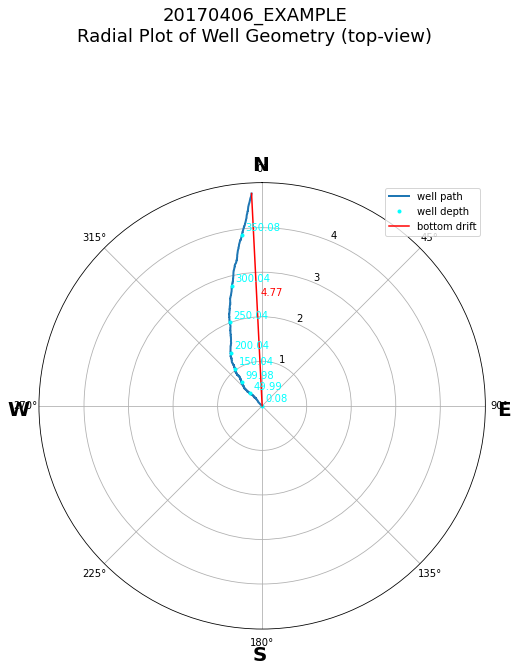

In [2]:
plot1 = DLPFL.PlotTopViewRadial(Depths, PathArray, JobID)

Now plot the well trajectory as viewed in the North/South-vertical and East/West-vertical planes.  Arguments same as above.

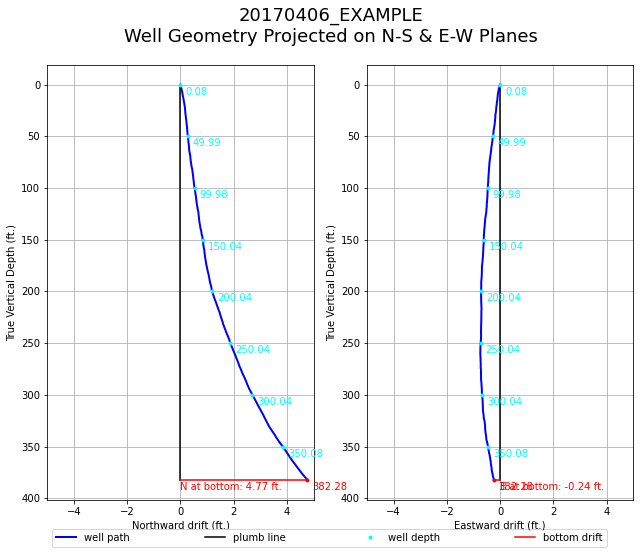

In [3]:
plot2 = DLPFL.PlotProjections(Depths, PathArray, JobID)

View the well trajectory plotted along axes in three-dimensional space.  Function arguments same as the above two functions.

/Users/ryaneaton/Documents/drift-log-analyzer-repo/DriftLogProgs/DriftLogPlotFuncLib.py:144: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes(ax)


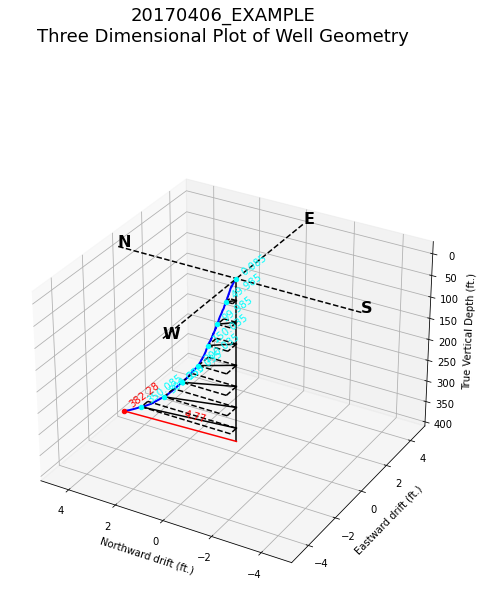

In [4]:
plot3 = DLPFL.Plot3DReconstruction(Depths, PathArray, JobID)

Next we compare radial departures from plumb against AWWA limit by
casing diameter per foot of well depth.  If well trajectory stays to the
left of the AWWA maximum boundary (blue dotted line), the well is within
spec.  For the plotting function below, argument `d_casing` should be
set to the diameter of casing in inches.

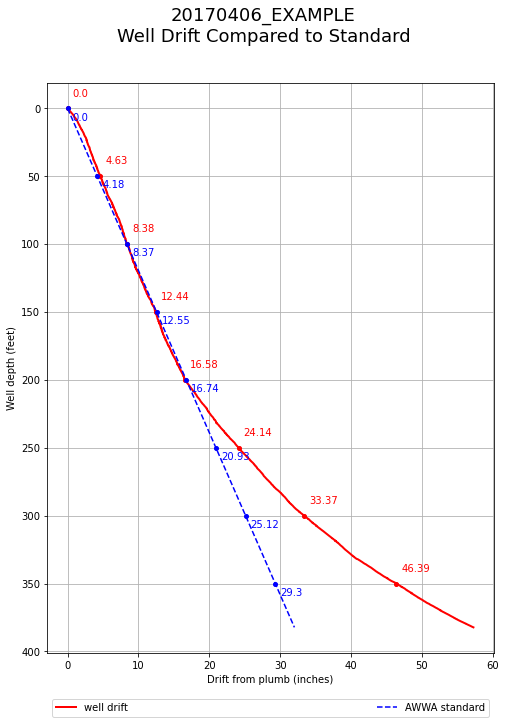

In [5]:
plot4 = DLPFL.WellStandardComparisonPlot(Depths, d_casing, PathArray, JobID)

Along the line spanning the radial center of the top of the well to the
radial center at the bottom of the pump, the function below finds the
depth at which cross-sectional clearence is minimal.  Argument `d_eff`
is the effective diameter output array generated by the
`EffectiveDiameter()` function upstream in the script. As above,
`d_casing` must contain the diameter of well casing in inches.

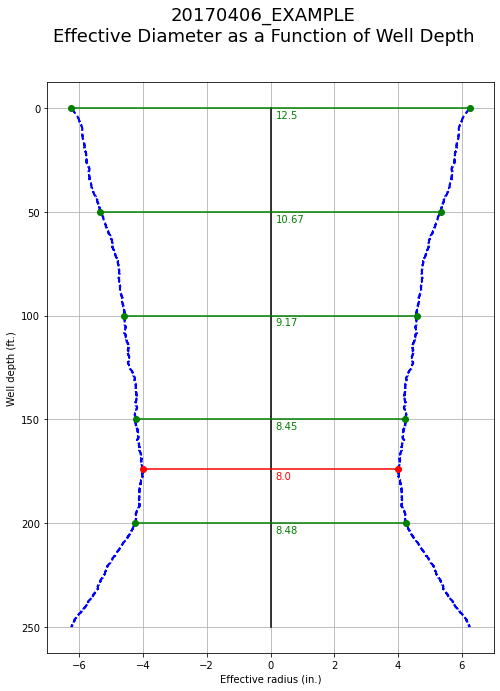

In [6]:
plot5 = DLPFL.PlotEffectiveDiameter(Depths[DepthSlice], 12*d_eff, 12*d_casing, JobID)

Below we show a diagram of offset circles to illustrate cross-sectional
clearence looking down from the top of the well.  Save arguments as the
function above.

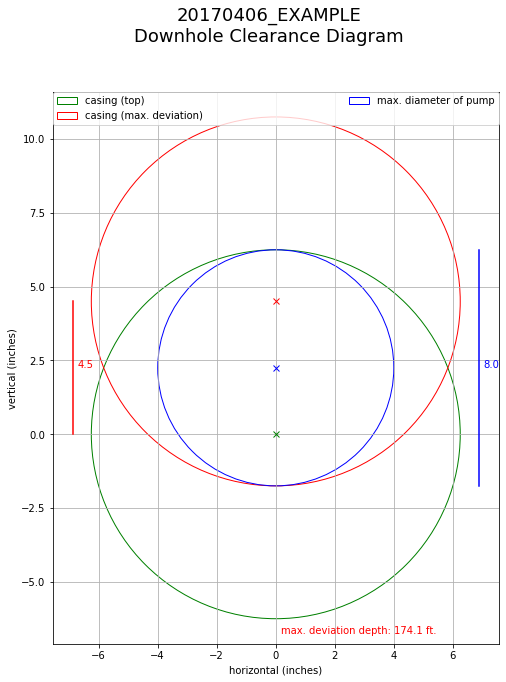

In [7]:
plot6 = DLPFL.ClearanceDiagram(Depths, 12*d_eff, 12*d_casing, JobID)

Finally we generate "dogleg" plot the well path trajectory with well depth. Extent of curvature is measured in degrees per 100 ft of arc: that is, the reciprocal radius of curvature about the point of interest multiplied by 100 (ft) gives a (unitless) angle that spans the arc. A smaller radius of curvature implies a tighter curve while a larger radius means a more gradual one. 

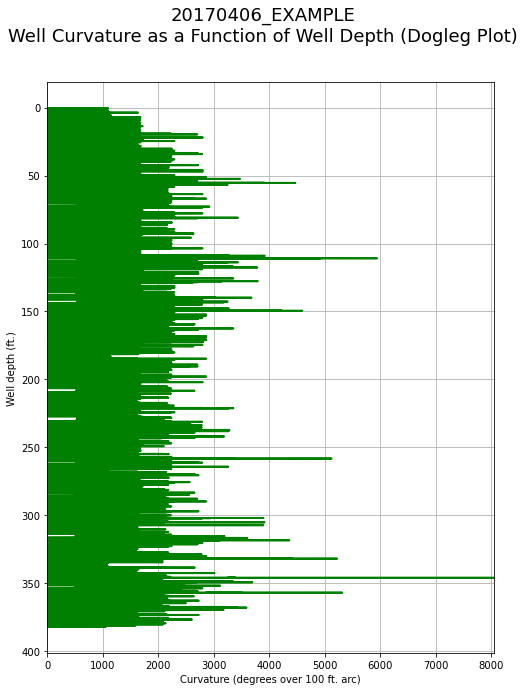

In [8]:
plot7 = DLPFL.PlotDoglegTrace(Depths[ValidFilter], AngleOver100ft, JobID)

In [11]:
#### BEGIN REPORT CONSOLIDATION AND SAVE #####
# Navigate to save directory
os.chdir(WriteDir)

# Save tabulated data to a .csv file
reportData.to_csv(JobID + 'DriftLogTabData.csv')

# Initialize a pdf object for merging together 
# separate plot figures as individual pages
pp = PdfPages(JobID + 'DriftLogReportFigs.pdf')

# Insert each report plot into pdf one by one.
pp.savefig(plot1)
pp.savefig(plot2)
pp.savefig(plot3)
pp.savefig(plot4)
pp.savefig(plot5)
pp.savefig(plot6)
pp.savefig(plot7)

# Close pdf object
pp.close()

# Return to original directory of script
os.chdir(CodeDir)

## Comparing bore trajectory computation methods

The script below calls four distinct routines for constructing the bore trajectory of a well from downhole gyroscopic logs. All four trajectories are plotted on a common set of 3 dimensional axes for comparison. The methods shown are: Average Angle (black), Balanced Tangential (cyan), Radius of Curvature (red) and Minimum Curvature (green).  Example LAS file used here: `20170406_1_Devdat.LAS`.

LAS file source? (0 = Eaton, 1 = Eaton (CSV)): 0


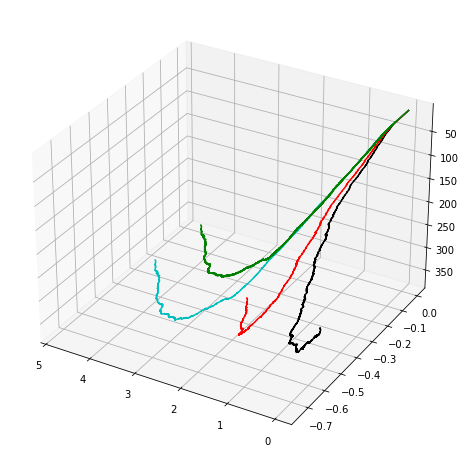

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun May 13 08:35:09 2018

@author: ryaneaton
"""
# Import NumPy
import numpy as np

# Load functions to import gyro log
import ImportLogDataScript_Gyro3 as ILDS_G

# Graphics generating libraries to import
import matplotlib.pyplot as plt
#import matplotlib.scatter as scatter
import matplotlib.patches as patches
import matplotlib.transforms as mtrans
from matplotlib.transforms import offset_copy
from mpl_toolkits.mplot3d import Axes3D

# Import drift trajectory calculation function library
import DriftPathCalcLib as DPCL

# Import gyro data
LogDataTable = ILDS_G.ImportData()

# Setup and initialize figure to be plotted
fig = plt.figure(figsize=(8,10.5))
ax = fig.add_subplot(111, projection='3d')

ASPECTRATIO = 0.8
#ax.set_aspect(ASPECTRATIO)
plt.gca().invert_zaxis()
plt.gca().invert_yaxis()

# Run average angle computation method
DelNorth, DelEast, DelTVD = DPCL.AverageAngleMethod(LogDataTable['Depth'], 
                                               LogDataTable['DevInclination'], 
                                               LogDataTable['DevAzimuth'], 
                                               AngleUnits='degrees')

# Plot AA trajectory
ax.plot(np.cumsum(DelNorth), np.cumsum(DelEast), np.cumsum(DelTVD),color='k')

# Run balanced tangential computation method
DelNorth, DelEast, DelTVD = DPCL.BalancedTangentialMethod(LogDataTable['Depth'], 
                                                     LogDataTable['DevInclination'], 
                                                     LogDataTable['DevAzimuth'], 
                                                     AngleUnits='degrees')

# Plot BT trajectory
ax.plot(np.cumsum(DelNorth), np.cumsum(DelEast), np.cumsum(DelTVD),color='c')

# Run radius of curvature computation method
DelNorth, DelEast, DelTVD = DPCL.RadiusOfCurvatureMethod(LogDataTable['Depth'], 
                                                     LogDataTable['DevInclination'], 
                                                     LogDataTable['DevAzimuth'], 
                                                     AngleUnits='degrees')

# Plot trajectory
ax.plot(np.cumsum(DelNorth), np.cumsum(DelEast), np.cumsum(DelTVD),color='r')

# Run minimum curvature computation method
DelNorth, DelEast, DelTVD = DPCL.MinimumCurvatureMethod(LogDataTable['Depth'], 
                                                     LogDataTable['DevInclination'], 
                                                     LogDataTable['DevAzimuth'], 
                                                     AngleUnits='degrees')

# Plot trajectory
ax.plot(np.cumsum(DelNorth), np.cumsum(DelEast), np.cumsum(DelTVD),color='g')




# Method: color of curve
# -----------------------------------
# AverageAngleMethod: Black
# BalancedTangentialMethod: Cyan
# RadiusOfCurvatureMethod: Red
# MinimumCurvatureMethod: Green